In [2]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the Dataset

## Dataset Loader

In [4]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os


class FashionMNISTDataset(Dataset):
    """Custom Dataset for loading FashionMNIST images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['image_name'].values
        self.y = df['class_label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        img = img.convert('L')
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [5]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

custom_test_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 8

In [7]:
train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files-kou2/',
                                    transform=custom_train_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid.csv',
                                    img_dir='png-files-kou2/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test.csv',
                                   img_dir='png-files-kou2/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

The cell below just checks if the dataset can be loaded correctly.

In [8]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 8
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 8
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [9]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE       
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probas = F.sigmoid(logits)
        return logits, probas

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=100*100,
            num_hidden_1=1000,
            num_classes=10)

model = model.to(DEVICE)




In [10]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.075)
############################################################

In [11]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 25 # Please feel free to change
############################################################

In [12]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 100*100).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 100*100).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 001/025 | Batch 000/1618 | Cost: 2.2966
Epoch: 001/025 | Batch 020/1618 | Cost: 2.2663
Epoch: 001/025 | Batch 040/1618 | Cost: 2.1093
Epoch: 001/025 | Batch 060/1618 | Cost: 2.0221
Epoch: 001/025 | Batch 080/1618 | Cost: 2.1951
Epoch: 001/025 | Batch 100/1618 | Cost: 1.6911
Epoch: 001/025 | Batch 120/1618 | Cost: 1.9843
Epoch: 001/025 | Batch 140/1618 | Cost: 2.0734
Epoch: 001/025 | Batch 160/1618 | Cost: 1.8200
Epoch: 001/025 | Batch 180/1618 | Cost: 1.9669
Epoch: 001/025 | Batch 200/1618 | Cost: 2.0240
Epoch: 001/025 | Batch 220/1618 | Cost: 1.5414
Epoch: 001/025 | Batch 240/1618 | Cost: 2.2322
Epoch: 001/025 | Batch 260/1618 | Cost: 1.9575
Epoch: 001/025 | Batch 280/1618 | Cost: 1.9419
Epoch: 001/025 | Batch 300/1618 | Cost: 1.9966
Epoch: 001/025 | Batch 320/1618 | Cost: 1.9900
Epoch: 001/025 | Batch 340/1618 | Cost: 1.7627
Epoch: 001/025 | Batch 360/1618 | Cost: 1.6451
Epoch: 001/025 | Batch 380/1618 | Cost: 1.9872
Epoch: 001/025 | Batch 400/1618 | Cost: 1.8071
Epoch: 001/02

# Evaluation 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'uppe\r right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


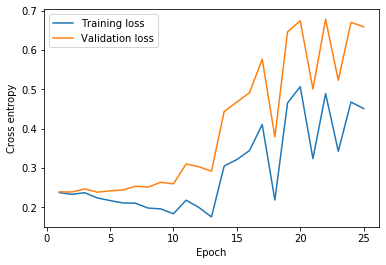

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='uppe\r right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

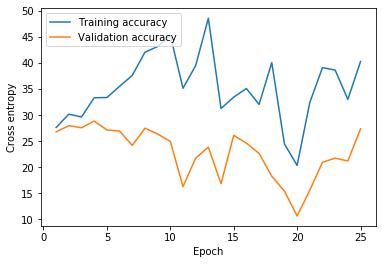

In [14]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [15]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 28.73%
